In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import scipy as sp
from collections import defaultdict
from itertools import product
import gurobipy as gb
from gurobipy import GRB

repeats = json.load(open('../cleanerdata/repeats.json'))
repeats = {int(k):v for k,v in repeats.items()}

locdem = pd.read_excel('../cleanerdata/locdem.xlsx')

q = locdem['Number of pallets'].to_numpy().astype(float).tolist()
q = [0] + q
q.extend([v['dem'] for v in repeats.values()])

locs = pd.read_excel('../cleanerdata/locations.xlsx')
longs, lats = locs['long'].to_numpy().tolist(), locs['lat'].to_numpy().tolist()
longs.extend([longs[v['map']] for v in repeats.values()])
lats.extend([lats[v['map']] for v in repeats.values()])

distmat = pd.read_json('../cleanerdata/distmat.json').to_numpy()
timemat = pd.read_json('../cleanerdata/timemat.json').to_numpy()
def get(i):
    try:
        i = repeats[i]['map']
    except KeyError:
        pass
    return i

def cost(i,j):
    i,j = get(i), get(j)
    return distmat[i,j]
def time(i,j):
    i,j = get(i), get(j)
    return timemat[i,j]

def location(i):
    return longs[i], lats[i]

In [2]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np


def get_even_clusters(X, cluster_size):
    n_clusters = int(np.ceil(len(X)/cluster_size))
    kmeans = KMeans(n_clusters)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_
    centers = centers.reshape(-1, 1, X.shape[-1]).repeat(cluster_size, 1).reshape(-1, X.shape[-1])
    distance_matrix = cdist(X, centers)
    clusters = linear_sum_assignment(distance_matrix)[1]//cluster_size
    return clusters

#https://stackoverflow.com/questions/5452576/k-means-algorithm-variation-with-equal-cluster-size

In [3]:
clusters = get_even_clusters(np.array(
    list(zip(longs[1:], lats[1:]))
), 5)

In [4]:
dikt = defaultdict(list)
for i,v in enumerate(clusters):
    dikt[v].append(i+1)
clusters = list(dikt.values())

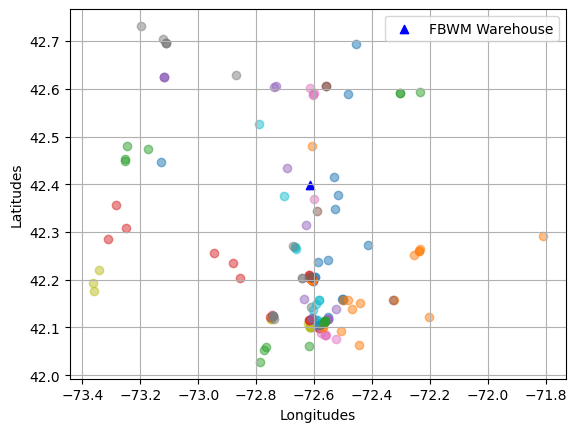

In [5]:
for cluster in clusters:
    X,Y = [],[]
    for i in cluster:
        pos  = location(i)
        X.append(pos[0])
        Y.append(pos[1])
    plt.scatter(X,Y, alpha=0.5)
plt.grid()
plt.scatter(longs[0], lats[0], color='blue', marker='^', label='FBWM Warehouse')
plt.legend()
plt.xlabel('Longitudes')
plt.ylabel('Latitudes')
plt.savefig('./clusters.png')

In [6]:
json.dump(clusters, open('./clusters.json', 'w'), indent=4)
